## Traditional machine learning
Feature(s): 'SMILES' column

- translate to morgan fingerprint

target: mp_bin

- binary class

In [1]:
import sys
import os
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from loguru import logger

logger.remove()
logger.add(sys.stderr, level="WARNING")
# Append the parent directory of your package to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..')))

Read the dataset from the zip file

In [2]:
import pandas as pd
import numpy as np
import zipfile

path_to_dataset = 'fats_data.csv'
csv_filename = 'fats_data.csv'

# Open the file, Correct the encoding and sep if necessary
if path_to_dataset.endswith('.zip'):
    with zipfile.ZipFile(path_to_dataset, 'r') as z:
        # Open the CSV file within the ZIP file
        with z.open(csv_filename) as f:
            # Read the CSV file into a DataFrame
            df = pd.read_csv(f, sep=',', on_bad_lines='warn', index_col = 0)
else:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path_to_dataset, sep=',', on_bad_lines='warn', index_col = 0)


print('Count of unique smiles:', df.SMILES.unique().shape[0])
print('Count of all of the smiles:', df.shape[0])



Count of unique smiles: 173
Count of all of the smiles: 211


In [3]:
from MLPipeline import MLmodel, BinTheTarget

Target = ['mp_bin']
Features = ['SMILES']
Feature_types = ['SMILES']
input = df

/home/lsmo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def objectiveRandomForestClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


def objectiveXGBClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize for XGBClassifier.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # L2 regularization
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


In [5]:
MODEL_NAMES = ['RandomForestClassifier', 'XGBClassifier']
TARGETS = [[i] for i in Target ]
TRAIN_SIZES = [25, 50, 100, 150]

result = []
for seed in [1, 2, 3]:
    for model_name in MODEL_NAMES:
        for target in TARGETS:
            for train_size in TRAIN_SIZES:
                print(f'RUN: Model:{model_name} / Target:{target} / Train size:{train_size} / Seed:{seed}')
                
                if model_name == 'RandomForestClassifier':
                    objective = objectiveRandomForestClassifier
                elif model_name == 'XGBClassifier':
                    objective = objectiveXGBClassifier

                model = MLmodel(modelType=model_name, 
                df=input,
                randomSeed=seed,
                train_count = train_size,
                test_count = 50, 
                target=target, 
                features=Features, 
                hyperparameter_tuning=True,
                feature_types=Feature_types,
                optimization_method='optuna', 
                optimization_trials=10,
                objective=lambda trial: objective(trial, model)
                )

                model.train()
                eval, summary = model.evaluate()
                result.append({**summary, **eval, 'seed':seed})



RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:25 / Seed:1


[I 2024-09-17 10:40:40,789] A new study created in memory with name: no-name-eb064ce1-0685-4585-a29f-d6cf6a308260
[I 2024-09-17 10:40:41,789] Trial 0 finished with value: 0.8 and parameters: {'n_estimators': 261, 'max_depth': 40, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.8.
[I 2024-09-17 10:40:43,262] Trial 1 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 259, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.8400000000000001.
[I 2024-09-17 10:40:44,147] Trial 2 finished with value: 0.8 and parameters: {'n_estimators': 194, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8400000000000001.
[I 2024-09-17 10:40:45,551] Trial 3 finished with value: 0.8 and parameters: {'n_estimators': 253, 'max_depth': 40, 

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:50 / Seed:1


[I 2024-09-17 10:40:51,909] A new study created in memory with name: no-name-d8633986-dcb4-4d13-817e-16cd58416e03
[I 2024-09-17 10:40:53,145] Trial 0 finished with value: 0.76 and parameters: {'n_estimators': 231, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.76.
[I 2024-09-17 10:40:53,893] Trial 1 finished with value: 0.76 and parameters: {'n_estimators': 194, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.76.
[I 2024-09-17 10:40:54,745] Trial 2 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 194, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.8400000000000001.
[I 2024-09-17 10:40:55,531] Trial 3 finished with value: 0.78 and parameters: {'n_estimators': 198, 'max_depth': 20, 'min_sample

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:100 / Seed:1


[I 2024-09-17 10:41:01,411] A new study created in memory with name: no-name-34618bb2-be74-48a8-b1de-07dbcc46886c
[I 2024-09-17 10:41:02,619] Trial 0 finished with value: 0.8600000000000001 and parameters: {'n_estimators': 255, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8600000000000001.
[I 2024-09-17 10:41:03,313] Trial 1 finished with value: 0.8700000000000001 and parameters: {'n_estimators': 160, 'max_depth': 40, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8700000000000001.
[I 2024-09-17 10:41:03,716] Trial 2 finished with value: 0.8700000000000001 and parameters: {'n_estimators': 61, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.8700000000000001.
[I 2024-09-17 10:41:05,226] Trial 3 finished with value: 0.8299999999999998

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:150 / Seed:1


[I 2024-09-17 10:41:11,432] A new study created in memory with name: no-name-49f88627-ab30-43a9-a347-335bd3f8ad50
[I 2024-09-17 10:41:12,424] Trial 0 finished with value: 0.8733333333333334 and parameters: {'n_estimators': 154, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8733333333333334.
[I 2024-09-17 10:41:13,766] Trial 1 finished with value: 0.8666666666666668 and parameters: {'n_estimators': 222, 'max_depth': 40, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8733333333333334.
[I 2024-09-17 10:41:14,057] Trial 2 finished with value: 0.8866666666666667 and parameters: {'n_estimators': 67, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.8866666666666667.
[I 2024-09-17 10:41:15,647] Trial 3 finished with value: 0.8733333333333334 

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:25 / Seed:1


[I 2024-09-17 10:41:20,051] A new study created in memory with name: no-name-fcc0e31c-4d36-450a-b3e5-b7082be2630e
[I 2024-09-17 10:41:20,361] Trial 0 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 65, 'max_depth': 13, 'learning_rate': 0.01898633340086326, 'subsample': 0.688535828773698, 'colsample_bytree': 0.7029923885737733, 'gamma': 1.9696944905285935e-05, 'reg_alpha': 0.0008235225655227914, 'reg_lambda': 0.018753478230614386}. Best is trial 0 with value: 0.8400000000000001.
[I 2024-09-17 10:41:20,602] Trial 1 finished with value: 0.8 and parameters: {'n_estimators': 131, 'max_depth': 6, 'learning_rate': 0.07909067621915691, 'subsample': 0.5502378696605678, 'colsample_bytree': 0.5005025869167173, 'gamma': 0.00044996261355514927, 'reg_alpha': 1.1327497223996059e-07, 'reg_lambda': 0.033048456991445686}. Best is trial 0 with value: 0.8400000000000001.
[I 2024-09-17 10:41:21,364] Trial 2 finished with value: 0.8 and parameters: {'n_estimators': 57, 'max_depth': 

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:50 / Seed:1


[I 2024-09-17 10:41:24,575] A new study created in memory with name: no-name-1eeb7323-06ae-44ea-8aa3-952842eeb6c6
[I 2024-09-17 10:41:25,248] Trial 0 finished with value: 0.8 and parameters: {'n_estimators': 195, 'max_depth': 15, 'learning_rate': 0.015411139760901431, 'subsample': 0.6543780637155837, 'colsample_bytree': 0.9453180202524781, 'gamma': 1.6949440221174414e-06, 'reg_alpha': 0.0005523755312754358, 'reg_lambda': 1.2711877551013946e-07}. Best is trial 0 with value: 0.8.
[I 2024-09-17 10:41:25,677] Trial 1 finished with value: 0.82 and parameters: {'n_estimators': 197, 'max_depth': 5, 'learning_rate': 0.09518202183114946, 'subsample': 0.9074672465429624, 'colsample_bytree': 0.85077142963187, 'gamma': 4.664352547898349e-05, 'reg_alpha': 1.5151489316507802e-08, 'reg_lambda': 2.6413299726412006e-07}. Best is trial 1 with value: 0.82.
[I 2024-09-17 10:41:25,951] Trial 2 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:100 / Seed:1


[I 2024-09-17 10:41:29,376] A new study created in memory with name: no-name-c76b989f-e7d7-4131-af8b-b8164ea693c6
[I 2024-09-17 10:41:30,000] Trial 0 finished with value: 0.8099999999999999 and parameters: {'n_estimators': 243, 'max_depth': 15, 'learning_rate': 0.2384522234749284, 'subsample': 0.5039866077938833, 'colsample_bytree': 0.8341986839149389, 'gamma': 3.2714131588644448e-06, 'reg_alpha': 1.818114804157226e-06, 'reg_lambda': 9.824436079299464e-06}. Best is trial 0 with value: 0.8099999999999999.
[I 2024-09-17 10:41:30,516] Trial 1 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 139, 'max_depth': 14, 'learning_rate': 0.07591778383492727, 'subsample': 0.9373160215617721, 'colsample_bytree': 0.7235288409102637, 'gamma': 2.7483138378700172e-05, 'reg_alpha': 1.2117799810197834e-08, 'reg_lambda': 0.0013548314805766162}. Best is trial 1 with value: 0.8400000000000001.
[I 2024-09-17 10:41:30,822] Trial 2 finished with value: 0.8400000000000001 and parameters: 

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:150 / Seed:1


[I 2024-09-17 10:41:36,562] A new study created in memory with name: no-name-fe43e7b2-0b14-46be-a941-64f77dac8700
[I 2024-09-17 10:41:36,969] Trial 0 finished with value: 0.8533333333333333 and parameters: {'n_estimators': 102, 'max_depth': 5, 'learning_rate': 0.20215767659516085, 'subsample': 0.5381050840515811, 'colsample_bytree': 0.6078863177404397, 'gamma': 0.1531097650242261, 'reg_alpha': 5.410284961593619e-05, 'reg_lambda': 6.338365935073725e-07}. Best is trial 0 with value: 0.8533333333333333.
[I 2024-09-17 10:41:37,775] Trial 1 finished with value: 0.9066666666666666 and parameters: {'n_estimators': 134, 'max_depth': 14, 'learning_rate': 0.015394969662265594, 'subsample': 0.6986529764081575, 'colsample_bytree': 0.5808845425240976, 'gamma': 0.12508978547049562, 'reg_alpha': 3.288630025612247e-08, 'reg_lambda': 8.99271807359195e-07}. Best is trial 1 with value: 0.9066666666666666.
[I 2024-09-17 10:41:38,717] Trial 2 finished with value: 0.86 and parameters: {'n_estimators': 292, 

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:25 / Seed:2


[I 2024-09-17 10:41:43,886] A new study created in memory with name: no-name-a040f47d-7712-4ff5-a5c0-01442f214a2a
[I 2024-09-17 10:41:44,260] Trial 0 finished with value: 0.9199999999999999 and parameters: {'n_estimators': 96, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9199999999999999.
[I 2024-09-17 10:41:45,422] Trial 1 finished with value: 0.6399999999999999 and parameters: {'n_estimators': 218, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9199999999999999.
[I 2024-09-17 10:41:45,653] Trial 2 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 56, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9199999999999999.
[I 2024-09-17 10:41:46,134] Trial 3 finished with value: 0.8 and paramet

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:50 / Seed:2


[I 2024-09-17 10:41:51,615] A new study created in memory with name: no-name-daf7d3ba-92cc-4c3b-b2b2-ea23a9a14ece
[I 2024-09-17 10:41:52,835] Trial 0 finished with value: 0.9199999999999999 and parameters: {'n_estimators': 226, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9199999999999999.
[I 2024-09-17 10:41:53,168] Trial 1 finished with value: 0.86 and parameters: {'n_estimators': 84, 'max_depth': 30, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9199999999999999.
[I 2024-09-17 10:41:54,057] Trial 2 finished with value: 0.82 and parameters: {'n_estimators': 168, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9199999999999999.
[I 2024-09-17 10:41:54,683] Trial 3 finished with value: 0.8800000000000001 and parameters: {'n_estima

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:100 / Seed:2


[I 2024-09-17 10:42:02,241] A new study created in memory with name: no-name-831b63f2-463f-4286-8dbe-0bf2fb17ee35
[I 2024-09-17 10:42:03,495] Trial 0 finished with value: 0.8799999999999999 and parameters: {'n_estimators': 233, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8799999999999999.
[I 2024-09-17 10:42:04,811] Trial 1 finished with value: 0.89 and parameters: {'n_estimators': 241, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.89.
[I 2024-09-17 10:42:05,144] Trial 2 finished with value: 0.9099999999999999 and parameters: {'n_estimators': 80, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.9099999999999999.
[I 2024-09-17 10:42:06,118] Trial 3 finished with value: 0.9099999999999999 and parameters: {'n_estima

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:150 / Seed:2


[I 2024-09-17 10:42:11,343] A new study created in memory with name: no-name-f03dd2ba-3c13-42c1-96d9-fba888d97234
[I 2024-09-17 10:42:12,240] Trial 0 finished with value: 0.8333333333333334 and parameters: {'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8333333333333334.
[I 2024-09-17 10:42:13,941] Trial 1 finished with value: 0.8333333333333334 and parameters: {'n_estimators': 297, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8333333333333334.
[I 2024-09-17 10:42:15,124] Trial 2 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 212, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 0.8400000000000001.
[I 2024-09-17 10:42:15,459] Trial 3 finished with value: 0.84666666666666

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:25 / Seed:2


[I 2024-09-17 10:42:21,763] A new study created in memory with name: no-name-c36ad76c-7a8f-42e4-bf9d-1ea46ebb5939
[I 2024-09-17 10:42:22,231] Trial 0 finished with value: 0.76 and parameters: {'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.01704901196997839, 'subsample': 0.5935724650168642, 'colsample_bytree': 0.6679012132520752, 'gamma': 1.3122367952674317e-06, 'reg_alpha': 0.2024193465782716, 'reg_lambda': 1.2231457986245459e-06}. Best is trial 0 with value: 0.76.
[I 2024-09-17 10:42:22,834] Trial 1 finished with value: 0.8 and parameters: {'n_estimators': 195, 'max_depth': 12, 'learning_rate': 0.08732366310729228, 'subsample': 0.9863450434086906, 'colsample_bytree': 0.7523569730208431, 'gamma': 3.101516936472777e-06, 'reg_alpha': 0.0018031500651046737, 'reg_lambda': 0.00012313126183317316}. Best is trial 1 with value: 0.8.
[I 2024-09-17 10:42:23,122] Trial 2 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 115, 'max_depth': 6, 'learning_rate': 0.0487

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:50 / Seed:2


[I 2024-09-17 10:42:26,584] A new study created in memory with name: no-name-16905291-c9e6-40fc-a318-56c9c0187ad9
[I 2024-09-17 10:42:26,907] Trial 0 finished with value: 0.9400000000000001 and parameters: {'n_estimators': 98, 'max_depth': 12, 'learning_rate': 0.03665667226293222, 'subsample': 0.776871280878421, 'colsample_bytree': 0.5659415399333989, 'gamma': 4.342297987958157e-08, 'reg_alpha': 4.193125353300712e-05, 'reg_lambda': 3.165780268476288e-08}. Best is trial 0 with value: 0.9400000000000001.
[I 2024-09-17 10:42:27,926] Trial 1 finished with value: 0.9199999999999999 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.023769162111798987, 'subsample': 0.8651411191371492, 'colsample_bytree': 0.896634062574817, 'gamma': 1.1371019934884386e-08, 'reg_alpha': 0.004150181917441025, 'reg_lambda': 0.19169455681739633}. Best is trial 0 with value: 0.9400000000000001.
[I 2024-09-17 10:42:28,529] Trial 2 finished with value: 0.9199999999999999 and parameters: {'n_es

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:100 / Seed:2


[I 2024-09-17 10:42:33,282] A new study created in memory with name: no-name-3c9174f8-1b43-4596-abda-87ab3d0ee5e9
[I 2024-09-17 10:42:34,015] Trial 0 finished with value: 0.9099999999999999 and parameters: {'n_estimators': 215, 'max_depth': 15, 'learning_rate': 0.016888655146290073, 'subsample': 0.917436750038904, 'colsample_bytree': 0.7867371320553778, 'gamma': 4.6661987789139355e-07, 'reg_alpha': 0.10778545303645495, 'reg_lambda': 0.17152630263951227}. Best is trial 0 with value: 0.9099999999999999.
[I 2024-09-17 10:42:34,251] Trial 1 finished with value: 0.89 and parameters: {'n_estimators': 70, 'max_depth': 11, 'learning_rate': 0.16515207536484572, 'subsample': 0.5174390081770921, 'colsample_bytree': 0.696794511423082, 'gamma': 9.053945346696087e-07, 'reg_alpha': 1.5394509421283237e-07, 'reg_lambda': 3.6170921413311677e-06}. Best is trial 0 with value: 0.9099999999999999.
[I 2024-09-17 10:42:34,927] Trial 2 finished with value: 0.9099999999999999 and parameters: {'n_estimators': 27

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:150 / Seed:2


[I 2024-09-17 10:42:40,088] A new study created in memory with name: no-name-49e33877-8917-47a8-beeb-d156bdb8910e
[I 2024-09-17 10:42:41,507] Trial 0 finished with value: 0.8266666666666665 and parameters: {'n_estimators': 231, 'max_depth': 6, 'learning_rate': 0.017226979156667807, 'subsample': 0.961840822039391, 'colsample_bytree': 0.7773415757106451, 'gamma': 0.00014523778848751643, 'reg_alpha': 0.06809775524761717, 'reg_lambda': 0.0002721789519954893}. Best is trial 0 with value: 0.8266666666666665.
[I 2024-09-17 10:42:41,808] Trial 1 finished with value: 0.82 and parameters: {'n_estimators': 59, 'max_depth': 9, 'learning_rate': 0.11808438583365445, 'subsample': 0.9138092197502969, 'colsample_bytree': 0.5272184029251349, 'gamma': 0.07487357208139024, 'reg_alpha': 0.7029444939003903, 'reg_lambda': 0.0015643410581416314}. Best is trial 0 with value: 0.8266666666666665.
[I 2024-09-17 10:42:42,919] Trial 2 finished with value: 0.8266666666666668 and parameters: {'n_estimators': 226, 'ma

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:25 / Seed:3


[I 2024-09-17 10:42:47,972] A new study created in memory with name: no-name-b733d6db-7dca-4aec-a379-afbfd80c0d03
[I 2024-09-17 10:42:49,086] Trial 0 finished with value: 0.6 and parameters: {'n_estimators': 208, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6.
[I 2024-09-17 10:42:49,674] Trial 1 finished with value: 0.6 and parameters: {'n_estimators': 98, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6.
[I 2024-09-17 10:42:50,667] Trial 2 finished with value: 0.64 and parameters: {'n_estimators': 261, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.64.
[I 2024-09-17 10:42:51,998] Trial 3 finished with value: 0.56 and parameters: {'n_estimators': 247, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf':

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:50 / Seed:3


[I 2024-09-17 10:42:56,648] A new study created in memory with name: no-name-9bfef99f-c030-4c97-b18c-8057ecb8c498
[I 2024-09-17 10:42:57,166] Trial 0 finished with value: 0.6799999999999999 and parameters: {'n_estimators': 134, 'max_depth': 40, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.6799999999999999.
[I 2024-09-17 10:42:58,020] Trial 1 finished with value: 0.7 and parameters: {'n_estimators': 204, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.7.
[I 2024-09-17 10:42:59,214] Trial 2 finished with value: 0.7000000000000001 and parameters: {'n_estimators': 218, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.7000000000000001.
[I 2024-09-17 10:42:59,879] Trial 3 finished with value: 0.6199999999999999 and parameters: {'n_estim

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:100 / Seed:3


[I 2024-09-17 10:43:05,685] A new study created in memory with name: no-name-079af9ad-d2e3-40e0-b26a-d0e465382585
[I 2024-09-17 10:43:06,404] Trial 0 finished with value: 0.8399999999999999 and parameters: {'n_estimators': 130, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8399999999999999.
[I 2024-09-17 10:43:06,888] Trial 1 finished with value: 0.8099999999999999 and parameters: {'n_estimators': 79, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8399999999999999.
[I 2024-09-17 10:43:07,938] Trial 2 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 179, 'max_depth': None, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.8400000000000001.
[I 2024-09-17 10:43:08,270] Trial 3 finished with value: 0.80999999999

RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:150 / Seed:3


[I 2024-09-17 10:43:14,172] A new study created in memory with name: no-name-d80c1f29-51b1-4e8d-9e28-b8c54d0e5302
[I 2024-09-17 10:43:15,516] Trial 0 finished with value: 0.8266666666666668 and parameters: {'n_estimators': 219, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8266666666666668.
[I 2024-09-17 10:43:16,268] Trial 1 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 156, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8400000000000001.
[I 2024-09-17 10:43:16,659] Trial 2 finished with value: 0.8800000000000001 and parameters: {'n_estimators': 86, 'max_depth': None, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.8800000000000001.
[I 2024-09-17 10:43:18,058] Trial 3 finished with value: 0.8533333333333

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:25 / Seed:3


[I 2024-09-17 10:43:24,098] A new study created in memory with name: no-name-6c951128-3b96-4c4c-a949-676dbc02e4cb
[I 2024-09-17 10:43:24,428] Trial 0 finished with value: 0.52 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.27276165767293453, 'subsample': 0.7904824068093024, 'colsample_bytree': 0.8451206400546447, 'gamma': 1.627955189593134e-05, 'reg_alpha': 0.04585935042374453, 'reg_lambda': 0.00039438878741720513}. Best is trial 0 with value: 0.52.
[I 2024-09-17 10:43:24,834] Trial 1 finished with value: 0.52 and parameters: {'n_estimators': 202, 'max_depth': 10, 'learning_rate': 0.02156777887730902, 'subsample': 0.6270758939343093, 'colsample_bytree': 0.5881467544663628, 'gamma': 4.9671433135804456e-06, 'reg_alpha': 7.312161062070922e-06, 'reg_lambda': 0.06954573046245491}. Best is trial 0 with value: 0.52.
[I 2024-09-17 10:43:25,015] Trial 2 finished with value: 0.6 and parameters: {'n_estimators': 62, 'max_depth': 5, 'learning_rate': 0.21694244458829845, '

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:50 / Seed:3


[I 2024-09-17 10:43:28,396] A new study created in memory with name: no-name-9bad2531-1501-4c19-8e85-ae2f86bc4f83
[I 2024-09-17 10:43:28,670] Trial 0 finished with value: 0.68 and parameters: {'n_estimators': 57, 'max_depth': 12, 'learning_rate': 0.021229398281625074, 'subsample': 0.9519278435605734, 'colsample_bytree': 0.929047410500059, 'gamma': 1.3425324221770018e-05, 'reg_alpha': 3.663636047933734e-06, 'reg_lambda': 8.848254862811322e-06}. Best is trial 0 with value: 0.68.
[I 2024-09-17 10:43:28,930] Trial 1 finished with value: 0.6799999999999999 and parameters: {'n_estimators': 95, 'max_depth': 5, 'learning_rate': 0.2460453167593444, 'subsample': 0.6657808550289264, 'colsample_bytree': 0.8911476636572275, 'gamma': 0.003657855631386812, 'reg_alpha': 2.854057800220749e-08, 'reg_lambda': 0.0004304354661465477}. Best is trial 0 with value: 0.68.
[I 2024-09-17 10:43:29,684] Trial 2 finished with value: 0.66 and parameters: {'n_estimators': 298, 'max_depth': 9, 'learning_rate': 0.01050

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:100 / Seed:3


[I 2024-09-17 10:43:35,570] A new study created in memory with name: no-name-e14afcfe-7296-4085-a4b2-35c5e1d37cb2
[I 2024-09-17 10:43:35,877] Trial 0 finished with value: 0.8300000000000001 and parameters: {'n_estimators': 61, 'max_depth': 11, 'learning_rate': 0.2280618742170779, 'subsample': 0.9761510559648265, 'colsample_bytree': 0.9842867130299099, 'gamma': 0.594351265676013, 'reg_alpha': 1.514642894758915e-08, 'reg_lambda': 0.13535704648500274}. Best is trial 0 with value: 0.8300000000000001.
[I 2024-09-17 10:43:36,547] Trial 1 finished with value: 0.82 and parameters: {'n_estimators': 196, 'max_depth': 3, 'learning_rate': 0.01848462647881486, 'subsample': 0.8529864062301273, 'colsample_bytree': 0.5053893861659459, 'gamma': 4.410680652089595e-08, 'reg_alpha': 0.003045978862623545, 'reg_lambda': 2.7501998800081586e-06}. Best is trial 0 with value: 0.8300000000000001.
[I 2024-09-17 10:43:37,156] Trial 2 finished with value: 0.8099999999999999 and parameters: {'n_estimators': 157, 'ma

RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:150 / Seed:3


[I 2024-09-17 10:43:42,701] A new study created in memory with name: no-name-9351fd1c-2307-4466-8f65-d47a40393942
[I 2024-09-17 10:43:43,668] Trial 0 finished with value: 0.8533333333333333 and parameters: {'n_estimators': 205, 'max_depth': 3, 'learning_rate': 0.01171446873973338, 'subsample': 0.882251348150551, 'colsample_bytree': 0.5079795063335215, 'gamma': 3.930789214743512e-06, 'reg_alpha': 0.00023159874501206968, 'reg_lambda': 2.7978719077244823e-06}. Best is trial 0 with value: 0.8533333333333333.
[I 2024-09-17 10:43:45,250] Trial 1 finished with value: 0.8333333333333334 and parameters: {'n_estimators': 218, 'max_depth': 9, 'learning_rate': 0.014698154050747366, 'subsample': 0.527004316548841, 'colsample_bytree': 0.8631657799769001, 'gamma': 1.5975627910565727e-07, 'reg_alpha': 0.00027961590744718015, 'reg_lambda': 3.1628724983622624e-08}. Best is trial 0 with value: 0.8533333333333333.
[I 2024-09-17 10:43:46,248] Trial 2 finished with value: 0.8400000000000001 and parameters: 

Some information about the dataset such as the splitting, wrong smiles, total number of samples.

In [6]:
df = pd.DataFrame(result)
display(df)
df.to_csv('fats_turino_traditional_ml.csv')

,modeltype,target,train_size,trues,preds,model_params,accuracy,f1_micro,f1_macro,kappa,seed
0,RandomForestClassifier,[mp_bin],25,"[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.82,0.82,0.810845,0.621849,1
1,RandomForestClassifier,[mp_bin],50,"[0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.80,0.80,0.797078,0.594156,1
2,RandomForestClassifier,[mp_bin],100,"[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, ...","[1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.86,0.86,0.859944,0.720000,1
3,RandomForestClassifier,[mp_bin],150,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, ...","[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.88,0.88,0.880000,0.763407,1
4,XGBClassifier,[mp_bin],25,"[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, ...","{'objective': 'binary:logistic', 'base_score':...",0.84,0.84,0.826389,0.653380,1
5,XGBClassifier,[mp_bin],50,"[0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, ...","{'objective': 'binary:logistic', 'base_score':...",0.84,0.84,0.837662,0.675325,1
6,XGBClassifier,[mp_bin],100,"[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, ...","[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","{'objective': 'binary:logistic', 'base_score':...",0.88,0.88,0.879808,0.760000,1
7,XGBClassifier,[mp_bin],150,"[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, ...","[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, ...","{'objective': 'binary:logistic', 'base_score':...",0.84,0.84,0.839744,0.681529,1
8,RandomForestClassifier,[mp_bin],25,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, ...","[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.84,0.84,0.840000,0.680511,2
9,RandomForestClassifier,[mp_bin],50,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.78,0.78,0.777778,0.555735,2


Text(0.5, 0.98, 'Random Forrest & XGB - MeltingPoint_molecules')

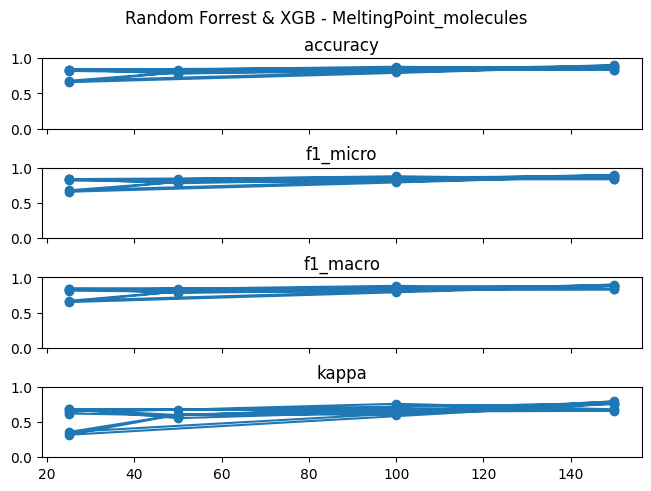

In [7]:
import matplotlib.pyplot as plt

METRICS = ['accuracy','f1_micro','f1_macro', 'kappa']
fig, ax = plt.subplots(len(METRICS), 1, sharex=True, layout = 'constrained')
ax = ax.flatten()

for i, metric in enumerate(METRICS):
    ax[i].plot(df['train_size'], df[metric], marker = 'o')
    ax[i].set_title(metric)
    ax[i].set_ylim(0,1)

fig.suptitle('Random Forrest & XGB - fats_turino')